# Analyzing the Spectrum of Explainability in Outcome-Oriented Predictive Process Monitoring

## BPIC2015_2_f2

### data preprocessing

#### importing libraries and terminology

In [15]:
#import libraries

In [16]:
import pandas as pd
from pandas import Series
import numpy as np
import time
import random
import pickle

from sklearn.preprocessing import StandardScaler
#MinMaxScaler

from sklearn.metrics import roc_auc_score
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OrdinalEncoder

#user specified packages from Teinemaa
import EncoderFactory
from DatasetManager import DatasetManager



#visualisation packages
import graphviz
from sklearn import tree
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

#import shap
import shap

#models
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

#IBM package models
from aix360.algorithms.rbm import FeatureBinarizer
from aix360.algorithms.rbm import LogisticRuleRegression

#LSTM
import logging
from collections import OrderedDict
from collections import defaultdict

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Embedding, LSTM, GRU, Dropout, Input, Reshape, Activation, Multiply, TimeDistributed, concatenate, BatchNormalization, Add
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

C:\Users\u0138175\Anaconda3\envs\aix360\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\u0138175\Anaconda3\envs\aix360\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\u0138175\Anaconda3\envs\aix360\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\u0138175\Anaconda3\envs\aix360\lib\site-packages\ten

In [17]:
#terminology

In [18]:
params_dir = './params_dir'
results_dir = './results' 
cls_encoding = 'agg'

gap = 1
n_iter = 1

dataset_ref_to_datasets = {
    "bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(1,6)],
    "insurance": ["insurance_activity", "insurance_followup"],
    "sepsis_cases": ["sepsis_cases_1", "sepsis_cases_2", "sepsis_cases_4"]
}

encoding_dict = {
    "laststate": ["static", "last"],
    "agg": ["static", "agg"],
    "index": ["static", "index"],
    "combined": ["static", "last", "agg"],
    "onehot": ["static", "onehot"]
}

train_ratio = 0.8
random_state = 22
n_iter = 1

In [19]:
dataset_ref = 'bpic2015_2_f2'
datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]
methods = encoding_dict[cls_encoding]

In [20]:
# print dataset name

In [21]:
for dataset_name in datasets:
    print('Dataset:', dataset_name)

Dataset: bpic2015_2_f2


In [22]:
# read the data

In [23]:
dataset_manager = DatasetManager(dataset_name)
data = dataset_manager.read_dataset()
cls_encoder_args = {'case_id_col': dataset_manager.case_id_col, 
                        'static_cat_cols': dataset_manager.static_cat_cols,
                        'static_num_cols': dataset_manager.static_num_cols, 
                        'dynamic_cat_cols': dataset_manager.dynamic_cat_cols,
                        'dynamic_num_cols': dataset_manager.dynamic_num_cols, 
                        'fillna': True}

In [24]:
# determine min and max (truncated) prefix lengths

In [25]:
min_prefix_length = 1
if "traffic_fines" in dataset_name:
    max_prefix_length = 10
elif "bpic2017" in dataset_name:
    max_prefix_length = min(20, dataset_manager.get_pos_case_length_quantile(data, 0.90))
else:
    max_prefix_length = min(40, dataset_manager.get_pos_case_length_quantile(data, 0.90))

#### EDA

In [26]:
#data types

In [27]:
data.dtypes

Responsible_actor                                            object
SUMleges                                                    float64
Case ID                                                      object
label                                                        object
Aanleg (Uitvoeren werk of werkzaamheid)                     float64
Bouw                                                        float64
Brandveilig gebruik (melding)                               float64
Brandveilig gebruik (vergunning)                            float64
Gebiedsbescherming                                          float64
Handelen in strijd met regels RO                            float64
Inrit/Uitweg                                                float64
Kap                                                         float64
Milieu (melding)                                            float64
Milieu (neutraal wijziging)                                 float64
Milieu (omgevingsvergunning beperkte milieutoets

In [28]:
#print first 5 rows of the data

In [29]:
data.head()

,Responsible_actor,SUMleges,Case ID,label,Aanleg (Uitvoeren werk of werkzaamheid),Bouw,Brandveilig gebruik (melding),Brandveilig gebruik (vergunning),Gebiedsbescherming,Handelen in strijd met regels RO,...,org:resource,time:timestamp,timesincemidnight,month,weekday,hour,timesincelastevent,timesincecasestart,event_nr,open_cases
0,560458,0.0000,3871304,regular,0.0,0.0,0.0,0.0,0.0,0.0,...,560532,2010-06-28 22:00:00,1320.0,6.0,0.0,22.0,0.0,0.0,1.0,1.0
1,560458,84.3000,3461877,regular,0.0,0.0,0.0,0.0,0.0,0.0,...,560458,2010-10-07 22:00:00,1320.0,10.0,3.0,22.0,0.0,0.0,1.0,2.0
2,560458,1698.2235,3466211,regular,0.0,1.0,0.0,0.0,0.0,0.0,...,560530,2010-10-10 22:00:00,1320.0,10.0,6.0,22.0,0.0,0.0,1.0,4.0
3,560458,84.3000,3467931,regular,0.0,0.0,0.0,0.0,0.0,0.0,...,560530,2010-10-10 22:00:00,1320.0,10.0,6.0,22.0,0.0,0.0,1.0,4.0
4,560458,84.3000,3461877,regular,0.0,0.0,0.0,0.0,0.0,0.0,...,560458,2010-10-11 22:00:00,1320.0,10.0,0.0,22.0,5760.0,5760.0,2.0,5.0


In [30]:
import pylab as pl

In [31]:
#histogram of the event numbers

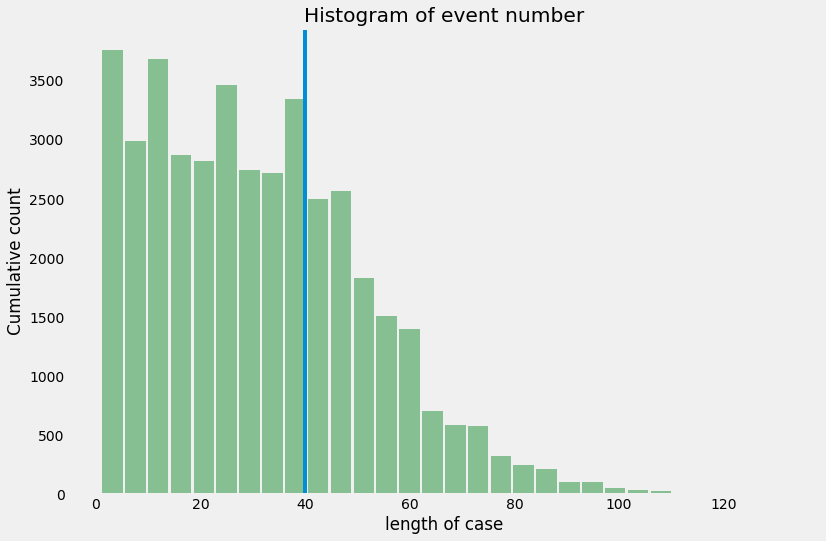

In [32]:
histo = data.hist(column='event_nr',bins=30, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
pl.title("Histogram of event number")
pl.xlabel("length of case")
pl.ylabel("Cumulative count")
plt.axvline(x=40, ymin=0, ymax=1)

In [33]:
#maximal length of an event

In [34]:
max_event = data['event_nr'].max()
max_event

132.0

#### data preprocessing

In [35]:
# split into training and test
train, test = dataset_manager.split_data_strict(data, train_ratio, split="temporal")

In [36]:
#prefix generation of train and test data

In [37]:
print('prefixing started')
dt_train_prefixes = dataset_manager.generate_prefix_data(train, min_prefix_length, max_prefix_length)
dt_test_prefixes = dataset_manager.generate_prefix_data(test, min_prefix_length, max_prefix_length)

prefixing started


In [38]:
dt_train_prefixes_original = dt_train_prefixes.copy()
dt_test_prefixes_original = dt_test_prefixes.copy()

In [39]:
#get the label of the train and test set
test_y = dataset_manager.get_label_numeric(dt_test_prefixes)
train_y = dataset_manager.get_label_numeric(dt_train_prefixes)   

In [40]:
auc_totals = []
preds_all = []
test_y_all = []
nr_events_all = []
offline_total_times = []
online_event_times = []

In [41]:
nr_events_all.extend(list(dataset_manager.get_prefix_lengths(dt_test_prefixes)))  
test_y_all.extend(test_y)

#### feature combiner and columns

In [106]:
feature_combiner = FeatureUnion([(method, EncoderFactory.get_encoder(method, **cls_encoder_args)) for method in methods])
feature_combiner.fit(dt_train_prefixes, train_y)
    
#transform train dataset and add the column names back to the dataframe
dt_train_named = feature_combiner.transform(dt_train_prefixes)
dt_train_named = pd.DataFrame(dt_train_named)
names= feature_combiner.get_feature_names()
dt_train_named.columns = names

In [107]:
#transform test dataset
dt_test_named = feature_combiner.transform(dt_test_prefixes)
dt_test_named = pd.DataFrame(dt_test_named)
names= feature_combiner.get_feature_names()
dt_test_named.columns = names

#### feature selection columns

aggregation columns

In [64]:
#all columns
columns_all = list(dt_train_named.columns)

In [65]:
#50 columns (10% PC)
columns_PC10 =['agg__Activity_08_AWB45_020_2',
 'static__Milieu (vergunning)',
 'agg__question_28',
 'agg__monitoringResource_4634935',
 'agg__Activity_08_AWB45_025',
 'agg__question_Uitgebreid',
 'agg__Activity_08_AWB45_170',
 'agg__Activity_01_HOOFD_330',
 'agg__org:resource_560530',
 'agg__org:resource_4634935',
 'agg__Activity_01_HOOFD_193',
 'agg__question_other',
 'agg__Activity_08_AWB45_060',
 'agg__Activity_01_HOOFD_191',
 'agg__Activity_08_AWB45_051_0',
 'agg__timesincelastevent_sum',
 'agg__Activity_01_HOOFD_490_1',
 'agg__Activity_01_HOOFD_250',
 'agg__Activity_08_AWB45_090_2',
 'static__Kap',
 'static__Milieu (neutraal wijziging)',
 'agg__Activity_08_AWB45_070_3',
 'static__Gebiedsbescherming',
 'agg__month_std',
 'agg__timesincecasestart_std',
 'agg__Activity_01_HOOFD_250_1',
 'agg__question_42',
 'agg__Activity_01_HOOFD_130',
 'agg__Activity_01_HOOFD_250_2',
 'agg__weekday_std',
 'agg__Activity_08_OLO_100',
 'agg__Activity_01_HOOFD_190_1',
 'static__Responsible_actor_560530',
 'agg__Activity_11_AH_II_010',
 'agg__Activity_08_AWB45_050',
 'agg__timesincecasestart_mean',
 'agg__weekday_max',
 'agg__timesincelastevent_max',
 'agg__Activity_08_AWB45_090_1',
 'agg__timesincelastevent_std',
 'agg__Activity_08_AWB45_020_0',
 'agg__timesincecasestart_sum',
 'agg__open_cases_std',
 'agg__timesincelastevent_mean',
 'agg__Activity_01_HOOFD_190_2',
 'static__Inrit/Uitweg',
 'agg__Activity_01_HOOFD_470',
 'agg__Activity_01_HOOFD_510_2',
 'agg__month_min',
 'agg__Activity_01_HOOFD_495']

In [66]:
#22 columns (15% correlation)
columns_PC15 = ['agg__Activity_08_AWB45_020_2',
 'static__Milieu (vergunning)',
 'agg__question_28',
 'agg__monitoringResource_4634935',
 'agg__Activity_08_AWB45_025',
 'agg__question_Uitgebreid',
 'agg__Activity_08_AWB45_170',
 'agg__Activity_01_HOOFD_330',
 'agg__org:resource_560530',
 'agg__org:resource_4634935',
 'agg__Activity_01_HOOFD_193',
 'agg__question_other',
 'agg__Activity_08_AWB45_060',
 'agg__Activity_01_HOOFD_191',
 'agg__Activity_08_AWB45_051_0',
 'agg__timesincelastevent_sum',
 'agg__Activity_01_HOOFD_490_1',
 'agg__Activity_01_HOOFD_250',
 'agg__Activity_08_AWB45_090_2',
 'static__Kap',
 'static__Milieu (neutraal wijziging)',
 'agg__Activity_01_HOOFD_490_2']

In [67]:
#12 columns (20% correlation)
columns_PC20 = ['agg__Activity_08_AWB45_020_2',
 'static__Milieu (vergunning)',
 'agg__question_28',
 'agg__monitoringResource_4634935',
 'agg__Activity_08_AWB45_025',
 'agg__question_Uitgebreid',
 'agg__Activity_08_AWB45_170',
 'agg__Activity_01_HOOFD_330',
 'agg__org:resource_560530',
 'agg__org:resource_4634935',
 'agg__Activity_01_HOOFD_193',
 'agg__question_other']

#### values to change

In [68]:
#############################
#######VALUES TO CHANGE######
#############################

In [108]:
columns = columns_all

In [109]:
column_selection = 'all'

In [110]:
cls_method ='glrm'
method_name = "%s_%s"%(column_selection, cls_encoding)

In [111]:
dt_train_named = dt_train_named[columns]
dt_test_named  = dt_test_named[columns]

In [112]:
if gap > 1:
    outfile = os.path.join(results_dir, "performance_results_%s_%s_%s_gap%s.csv" % (cls_method, dataset_name, method_name, gap))
else:
    outfile = os.path.join(results_dir, "performance_results_%s_%s_%s.csv" % (cls_method, dataset_name, method_name))

In [113]:
# load optimal params

In [114]:
optimal_params_filename = os.path.join(params_dir, "optimal_params_%s_%s_%s.pickle" % (cls_method, dataset_name, method_name))
if not os.path.isfile(optimal_params_filename) or os.path.getsize(optimal_params_filename) <= 0:
    print('problem')

with open(optimal_params_filename, "rb") as fin:
    args = pickle.load(fin)
    print(args)

{'lambda0': 0.002506433922159593, 'lambda1': 0.002304030840029294}


### LLM

#### model

In [76]:
current_args = args 

In [77]:
args

{'max_depth': 1, 'min_samples_leaf': 310}

In [80]:
#dt_train_named = dt_train_named[columns]
#first, create,train and fit a DecisionTreeClassifier
cls = DecisionTreeClassifier(criterion= 'entropy', 
                                 max_depth= args['max_depth'], 
                                 min_samples_leaf= args['min_samples_leaf'], 
                                 random_state = random_state)
cls.fit(dt_train_named,train_y)
dt_test_named = dt_test_named[columns]
    
#add an extra column with the number of the leave node
#these can be seen as the homogeneuous segments (buckets)
dt_train_named['cluster'] = cls.apply(dt_train_named)
dt_test_named['cluster'] = cls.apply(dt_test_named)
cluster_number = list(dt_test_named['cluster'] )
train_y_concat = pd.DataFrame(train_y)
train_y_concat = train_y_concat.rename(columns={train_y_concat.columns[0]:'label'})
dt_train_named = pd.concat([dt_train_named,train_y_concat], axis=1)
test_y_concat  = pd.DataFrame(test_y)
test_y_concat  = test_y_concat.rename(columns={test_y_concat.columns[0]:'label'})
dt_test_named = pd.concat([dt_test_named, test_y_concat], axis=1)
    
#list of leaves that contain test data 
leaves = list((dt_test_named['cluster'].unique()))
a = np.array(cluster_number)
b = np.array(nr_events_all)

#reorder the event numbers
event_list = []
for i in leaves:
    event_list.extend(b[a==i].tolist())

In [81]:
leaves

[1, 2]

In [82]:
classifiers = []
aucs = []
auc_totals = []
preds_all = []
test_y_all = []
print('model after DT started')
avg_runtime = []
start = time.time()
for i in leaves:  
    #only take the data from the leave, seperate the label from the independent features
    data_train_x = dt_train_named[dt_train_named['cluster']==i].copy()
    data_train_y = data_train_x['label'].copy()
    
    data_test_x  = dt_test_named[dt_test_named['cluster']==i].copy()
    data_test_y  = data_test_x['label'].copy()
        
    #drop the columns
    data_train_x = data_train_x.drop('label', axis=1)
    data_train_x = data_train_x.drop('cluster', axis=1)
    data_test_x = data_test_x.drop('label', axis=1)
    data_test_x = data_test_x.drop('cluster', axis=1)
        
    
    #if there is only one label in the training data, no need to create a leaf model
    if len(set(data_train_y))<2:
        pred = [data_train_y.iloc[0]]*len(data_test_y)
        preds_all.extend(pred)
        test_y_all.extend(data_test_y)
        classifiers.append('only one training label')
        try:
            auc = roc_auc_score(data_test_y,preds)
            aucs.append(auc)
        except:
            #perfect classifcation so an AUC of 1
            auc=1
            aucs.append(auc)
                
    else:  
        #print length of test and training data of the leaf node
        l = [["length test data", len(data_test_x)], ["length training data", len(dt_train_named)]]
        table = tabulate(l, tablefmt='orgtbl')
        print(table)
        test_y_all.extend(data_test_y)
            
        if cls_method == 'llm':
                scaler = StandardScaler()
                data_train_x2= scaler.fit_transform(data_train_x)
                data_test_x2= scaler.transform(data_test_x)
                data_train_x = pd.DataFrame(data_train_x2, columns = data_train_x.columns)
                data_test_x = pd.DataFrame(data_test_x2, columns = data_test_x.columns)
                preds_pos_label_idx = np.where(cls.classes_ == 1)[0][0]
                logreg = LogisticRegression(max_iter= 10000000, 
                                            solver='saga', 
                                            penalty= 'elasticnet',
                                            l1_ratio = 0.9,
                                            n_jobs =-1)     
                logreg.fit(data_train_x, data_train_y)
                
                pred = logreg.predict_proba(data_test_x)
                pred = pred[:,preds_pos_label_idx]
                odds = np.exp(logreg.coef_[0])
                odds = np.exp(logreg.coef_[0])
                logmodel = pd.DataFrame(odds, pd.DataFrame(data_train_x).columns, columns=['coef']).sort_values(by='coef', ascending=False)
                coefs = {"coef": ["coef_%s"%i]}
                coef = coefs['coef'][0]
                coefhelp = logmodel
                exec(coef + "=coefhelp")
                        
                #this seperation is solely to be able to calculate the AUC for every leaf node model
                if len(set(data_test_y))>1:
                    auc = roc_auc_score(data_test_y, pred)
                    print(auc)
                    aucs.append(auc)
                    preds_all.extend(pred)
                    classifiers.append('leaf model')                    
                            
                elif len(set(data_test_y))==1:
                    auc = 1
                    aucs.append(auc)
                    preds_all.extend(pred)
                    classifiers.append('leaf model')
                    
total_time = time.time() - start
avg_runtime.append(total_time/ (len(dt_train_named)+len(dt_test_named)))

auc_total = roc_auc_score(test_y_all, preds_all)
    
    

print("results are up")

model after DT started
| length test data     |  5372 |
| length training data | 22221 |
0.8512255836937279
results are up


In [83]:
cf = []
for i in leaves:
    coefficients = "coef_%s"%i
    cf.append(coefficients)

In [84]:
cf

['coef_1', 'coef_2']

In [85]:
with open(outfile, 'w') as fout:
        fout.write("%s;%s;%s;%s;%s;%s\n"%("dataset", "method", "cls", "nr_events", "metric", "score"))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "runtime_total", total_time))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "runtime_avg", avg_runtime[0]))  
        dt_results = pd.DataFrame({"actual": test_y_all, "predicted": preds_all, "nr_events": event_list})
        for nr_events, group in dt_results.groupby("nr_events"):
            if len(set(group.actual)) < 2:
                fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, nr_events,-1, "auc", np.nan))
            else:
                fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, nr_events,-1, "auc", roc_auc_score(group.actual, group.predicted)))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "auc", roc_auc_score(dt_results.actual, dt_results.predicted)))
        fout.write("%s\n"%(aucs))
        fout.write("%s\n"%(coef_1))

In [86]:
method_name

'PC15_agg'

In [87]:
auc_total

0.9159843849460405

aucs

In [ ]:
leaves

In [ ]:
classifiers

In [ ]:
#plot the decison tree
# DOT data
dot_data = tree.export_graphviz(cls, out_file=None, 
                                feature_names=dt_train_named[columns].columns,  
                                class_names=['regular','deviant'],
                                filled=True)

In [ ]:
# Draw graph

graph = graphviz.Source(dot_data, format="png") 
graph.render("llm_agg_bpic2015_2_f2_DT.png")

In [ ]:
#textual representation of the DT
text_representation = tree.export_text(cls)
print(text_representation)

In [ ]:
#define decision rules per leaf node

n_nodes = cls.tree_.node_count
children_left = cls.tree_.children_left
children_right = cls.tree_.children_right
feature = cls.tree_.feature
threshold = cls.tree_.threshold

def find_path(node_numb, path, x):
        path.append(node_numb)
        if node_numb == x:
            return True
        left = False
        right = False
        if (children_left[node_numb] !=-1):
            left = find_path(children_left[node_numb], path, x)
        if (children_right[node_numb] !=-1):
            right = find_path(children_right[node_numb], path, x)
        if left or right :
            return True
        path.remove(node_numb)
        return False
def get_rule(path, column_names):
    mask = ''
    for index, node in enumerate(path):
        #We check if we are not in the leaf
        if index!=len(path)-1:
            # Do we go under or over the threshold ?
            if (children_left[node] == path[index+1]):
                mask += "(df['{}']<= {}) \t ".format(column_names[feature[node]], threshold[node])
            else:
                mask += "(df['{}']> {}) \t ".format(column_names[feature[node]], threshold[node])
    # We insert the & at the right places
    mask = mask.replace("\t", "&", mask.count("\t") - 1)
    mask = mask.replace("\t", "")
    return mask

In [ ]:
#for all the leave nodes:

# Leave node
leave_id = cls.apply(dt_train_named[columns])
paths ={}
for leaf in np.unique(leave_id):
    path_leaf = []
    find_path(0, path_leaf, leaf)
    paths[leaf] = np.unique(np.sort(path_leaf))
rules1 = {}
for key in paths:
    rules1[key] = get_rule(paths[key], dt_train_named.columns)

rules1

In [ ]:
coef_1

### GLRM

In [115]:
classifiers = []
aucs = []
auc_totals = []
preds_all = []
test_y_all = []
nr_events_all = []
avg_runtime = []
start = time.time()
dt_train_named = dt_train_named[columns]
dt_test_named = dt_test_named[columns]
nr_events_all.extend(list(dataset_manager.get_prefix_lengths(dt_test_prefixes)))
len_testdata = len(dt_test_named)
len_traindata = len(dt_train_named)
test_y_all.extend(test_y)
  
    #Featurebinarizer
"We assume that all features Xj have been binarized to take values in {0, 1}. Categorical and numerical features were binarized" 
"using sample deciles as thresholds for numerical features."
                
"For categorical features, this is achieved through the usual “one-hot” coding into indicators Xj = x for all categories"
"x as well as their negations Xj != x  (From GLRM, Dennis Wei)"

"==> The categorical features have already been onehotencoded by Teinemaa. Therefore, the negations will not be added as features."
"This should not cause any problems as one of the parameters of the featurebinarizer allows you to exclude these negations"
        
"Numerical features are binarized through bi-directional comparisons to a set of thresholds, e.g., Xj ≤ 1, Xj ≤ 2.3 and Xj > 1, Xj > 2.3"
"ordinal features can optionally be standardized"
            
"Then what does it do next?"
"Once the column generation algorithm terminates, we solve the log-likelihood problem (4) one last time to de-bias the solution."
"In this final run we restrict conjunctions to the ones with β±k > 10−5 in the last round and we drop the regularization term in the objective."
fb = FeatureBinarizer(negations=False, returnOrd=True, threshStr=False, numThresh=10 )
'threshStr= False :Convert thresholds on ordinal features to strings'
'returnOrd= True: return standardized ordinal features'
'negations= False: do not compute negations of categorical features'
'numTresh: raising this number will improve the performance'
dt_train_named, dfTrainStd = fb.fit_transform(dt_train_named)
dt_test_named, dfTestStd = fb.transform(dt_test_named)
'lambda0 = 0.001  : Regularization - fixed cost of each rule'
'lambda1 = 0.00005: Regularization - additional cost of each literal in rule'
'iterMax= pow(1000,1000): Column generation - maximum number of iterations, intentionally very high numberoes not add much to runtime'           
cls= LogisticRuleRegression(lambda0=args['lambda0'], lambda1=args['lambda1'], iterMax= 10000)   
    # Train, print, and evaluate model
cls.fit(dt_train_named, pd.Series(train_y))

                
pred = cls.predict_proba(dt_test_named)
preds_all.extend(pred)      

total_time = time.time() - start
avg_runtime.append(total_time/ (len_traindata+len_testdata))
auc_total = roc_auc_score(test_y_all, preds_all)
   
print("results are up")

results are up


The max_iter was reached which means the coef_ did not converge


In [124]:
with open(outfile, 'w') as fout:
        fout.write("%s;%s;%s;%s;%s;%s\n"%("dataset", "method", "cls", "nr_events", "metric", "score"))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "runtime_total", total_time))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "runtime_avg", avg_runtime[0]))  
        dt_results = pd.DataFrame({"actual": test_y_all, "predicted": preds_all, "nr_events": nr_events_all})
        for nr_events, group in dt_results.groupby("nr_events"):
            if len(set(group.actual)) < 2:
                fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, nr_events,-1, "auc", np.nan))
            else:
                fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, nr_events,-1, "auc", roc_auc_score(group.actual, group.predicted)))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "auc", roc_auc_score(dt_results.actual, dt_results.predicted)))
        fout.write("%s\n"%(explanations))

In [116]:
len(nr_events_all)

5789

In [117]:
auc_total

0.9565277139766704

In [122]:
explanations = cls.explain()

In [119]:
explanations = cls.explain()

In [120]:
for i in range(0,len(explanations)):
    print(explanations['rule'].iloc[i])

(intercept)
agg__Activity_08_AWB45_010  
agg__Activity_08_AWB45_020_2 <= 0.00
agg__Activity_08_AWB45_020_2 <= 0.00 AND agg__org:resource_4634935 <= 0.00
agg__Activity_01_HOOFD_260 <= 0.00 AND agg__org:resource_560530 <= 9.00 AND agg__open_cases_std <= 11.38
agg__Activity_01_HOOFD_195  
static__Milieu (vergunning)  
static__Kap  
static__SUMleges <= 0.00
agg__Activity_08_AWB45_020_2 <= 0.00 AND agg__monitoringResource_4634935 <= 1.00
static__SUMleges <= 792.42 AND agg__Activity_08_AWB45_020_2 <= 0.00
agg__timesincecasestart_mean <= 27527.86
agg__org:resource_560532 <= 5.00
static__Bouw  
agg__question_EMPTY <= 9.00
agg__Activity_08_AWB45_020_2 <= 0.00 AND agg__monitoringResource_560519 <= 0.00
agg__event_nr_max <= 23.00
agg__timesincecasestart_mean <= 19024.56
agg__monitoringResource_560458 <= 0.00
agg__org:resource_560530 <= 0.00
agg__weekday_max <= 2.00
static__SUMleges <= 2051.19 AND agg__Activity_08_AWB45_020_2 <= 0.00
agg__monitoringResource_560458 <= 4.00
agg__Activity_01_HOOFD_20

In [121]:
for i in range(0,len(explanations)):
    print(explanations['coefficient'].iloc[i])

5.279367362814574
18.041489490323823
-16.1145763595609
-9.209880952855576
4.9900001404078695
-4.8664147996827785
3.996777724161332
-2.6715074003182235
2.527223790673218
-2.3205815143183086
-2.259323446600872
1.91649182400554
1.815943984503405
1.3903380223708544
1.374563783401942
-1.1900420595943897
1.1734461449199363
1.1007546683145464
1.0925088437945285
1.0881859843252006
-1.025037856706845
-0.38721194242563145
-0.38229969770103395
0.37243625135299174
-0.2907464599403768
0.26792874854221765
0.23994889535779862
-0.19093891921939257
-0.11266135083524163
-0.1028970426734841
0.051834184432032804
-0.018014259581105845


### XGBoost

###### model

In [102]:
current_args= args

In [103]:
classifiers = []
aucs = []
auc_totals = []
preds_all = []
test_y_all = []
avg_runtime = []
nr_events_all = []
start = time.time()
#dt_train_named = dt_train_named[columns]
#dt_test_named = dt_test_named[columns]
nr_events_all.extend(list(dataset_manager.get_prefix_lengths(dt_test_prefixes)))
len_testdata = len(dt_test_named)
len_traindata = len(dt_train_named)
test_y_all.extend(test_y)


cls = xgb.XGBClassifier(objective='binary:logistic',
                                                n_estimators=500,
                                                learning_rate= current_args['learning_rate'],
                                                subsample=current_args['subsample'],
                                                max_depth=int(current_args['max_depth']),
                                                colsample_bytree=current_args['colsample_bytree'],
                                                min_child_weight=int(current_args['min_child_weight']),
                                                seed=random_state)
cls.fit(dt_train_named, train_y)
preds_pos_label_idx = np.where(cls.classes_ == 1)[0][0]
pred = cls.predict_proba(dt_test_named)[:,preds_pos_label_idx]
    
preds_all.extend(pred)

    
total_time = time.time() - start
avg_runtime.append(total_time/ (len_traindata+len_testdata))
auc_total = roc_auc_score(test_y_all, preds_all)
   
print("results are up")
        
with open(outfile, 'w') as fout:
        fout.write("%s;%s;%s;%s;%s;%s\n"%("dataset", "method", "cls", "nr_events", "metric", "score"))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "runtime_total", total_time))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "runtime_avg", avg_runtime[0]))  
        dt_results = pd.DataFrame({"actual": test_y_all, "predicted": preds_all, "nr_events": nr_events_all})
        for nr_events, group in dt_results.groupby("nr_events"):
            if len(set(group.actual)) < 2:
                fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, nr_events,-1, "auc", np.nan))
            else:
                fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, nr_events,-1, "auc", roc_auc_score(group.actual, group.predicted)))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "auc", roc_auc_score(dt_results.actual, dt_results.predicted)))

results are up


In [104]:
auc_total

0.9288031498036557

In [ ]:
len(columns)

In [ ]:
shap_values = shap.TreeExplainer(cls).shap_values(dt_train_named)
shap.summary_plot(shap_values, dt_train_named, plot_type="bar", max_display=12)

In [ ]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(dt_train_named.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.head(12)

In [ ]:
cols = list(feature_importance['col_name'][0:22])

In [ ]:
cols

In [ ]:
for i in cols:
    print(i)

In [ ]:
shap.summary_plot(shap_values, dt_train_named[columns])

In [ ]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,dt_train_named[columns]) 